<a href="https://colab.research.google.com/github/beneyoung/KBDB---Team-Wine_quality/blob/main/Wine_quality_lgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 설치

In [1]:
!pip install category_encoders==2.*
!pip install pandas-profiling==3.1.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

In [5]:
train = pd.read_csv("https://raw.githubusercontent.com/beneyoung/KBDB---Team-Wine_quality/main/Wine_quality/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/beneyoung/KBDB---Team-Wine_quality/main/Wine_quality/test.csv")
# submission = pd.read_csv("https://raw.githubusercontent.com/beneyoung/KBDB---Team-Wine_quality/main/Wine_quality/sample_submission.csv")
train = train.drop(['index'], axis=1)
test = test.drop(['index'], axis=1)

- index : 구분자
- quality : 품질
- fixed acidity : 산도 *
- volatile acidity : 휘발성산 *
- citric acid : 시트르산 *
- residual sugar : 발효 후 와인 속에 남아있는 당분 *
- chlorides : 염화물 *
-- 이산화황 : 보존재 역할 적게 들어갈 수록 좋음, SO2가 이미 반응하여 다른 기능을 사용할 수 없게 되면 '결합'된 것으로 간주. 총량은 free와 bound의 합.
- free sulfur dioxide : 독립 이산화황*
- total sulfur dioxide : 총 이산화황 *
- density : 밀도, 바디의 무게감 *
- pH : 와인의 산도 *
- sulphates : 황산염 *
- alcohol : 도수 *
- type : 종류

In [6]:
df = train
df = pd.get_dummies(df, columns = ['type'])
df.head(3)

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0,1
1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1,0
2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0,1


In [7]:
test = pd.get_dummies(test, columns = ['type'])
test.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.9938,2.90,0.38,11.6,0,1
1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.0004,3.06,0.49,9.0,1,0
2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.9948,3.19,0.69,9.4,0,1


In [8]:
# feature명 정리
target = 'quality'
features = list(df.columns)
features.remove(target)

numeric = features
numeric.remove('type_red')
numeric.remove('type_white')

nominal = ['type_red', 'type_white']

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df[numeric])
df1 = scaler.transform(df[numeric])
df2 = pd.DataFrame(df1, columns=df[numeric].columns)

aa = pd.concat([df[target],df2],axis=1)
df = pd.concat([aa,df[nominal]],axis=1)
df.head(3)

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,5,-1.250611,2.186377,-1.78194,0.286345,-0.398500,-1.211937,-0.560852,-0.117252,1.372128,-0.605988,-0.255287,0,1
1,5,1.234899,1.665574,-1.23056,-0.638755,0.322998,-1.155351,-1.307080,0.738864,-0.183584,0.398147,-0.841348,1,0
2,5,0.535849,-0.785265,0.49250,-0.722855,0.034399,-0.532907,0.398583,-0.966732,-1.054782,-0.070450,0.330774,0,1


In [10]:
scaler.fit(test[numeric])
test1 = scaler.transform(test[numeric])
test2 = pd.DataFrame(test1, columns=test[numeric].columns)

test4 = pd.concat([test2,test[nominal]],axis=1)
test4.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,1.306951,-0.220579,1.098184,0.236865,-0.385503,-1.108531,-0.756734,-0.352060,-1.943080,-1.068114,1.000172,0,1
1,4.507070,0.477272,1.780836,-0.749722,0.343645,-0.888114,-1.327873,1.915724,-0.949812,-0.311854,-1.203025,1,0
2,-0.553583,-0.395042,-0.335387,-0.057012,-0.466520,0.709907,1.077835,-0.008456,-0.142782,1.063164,-0.864071,0,1


#### 데이터 특성


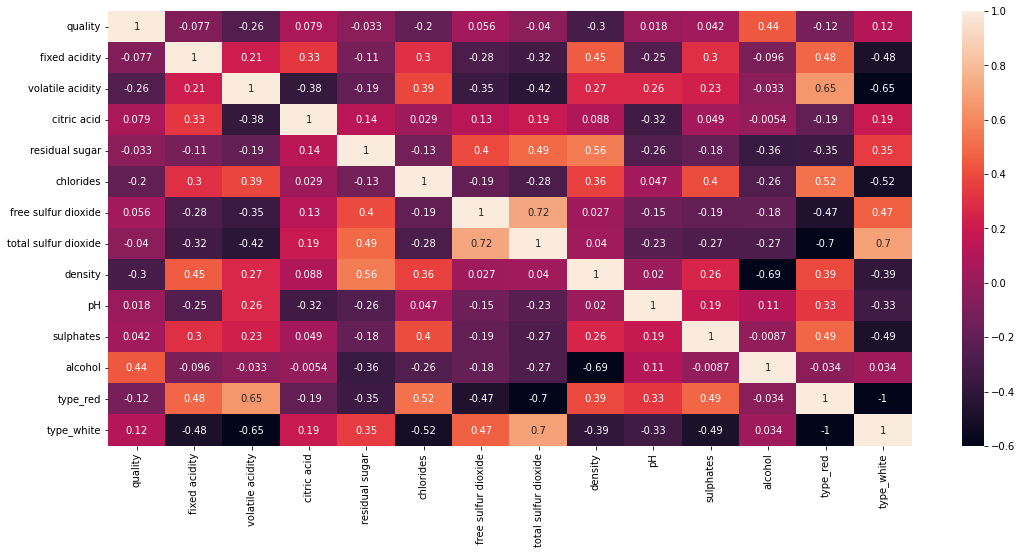

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.figure(figsize=(18,8))
corr= df.corr()
sns.heatmap(corr, annot=True, square=False, vmin=-.6, vmax=1.0);

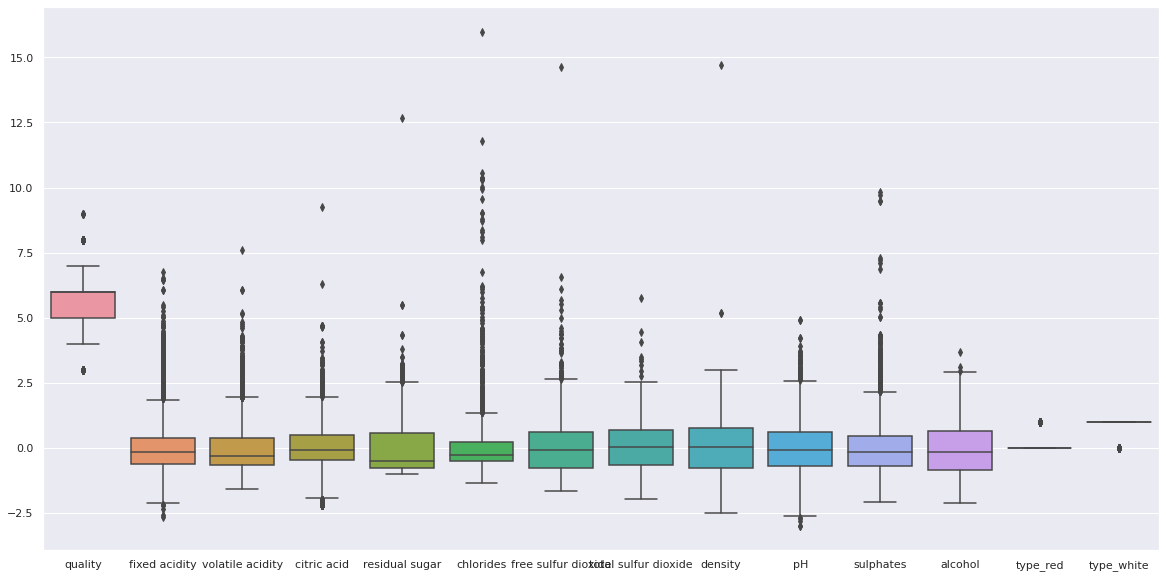

In [12]:
sns.set()
plt.figure(figsize=(20,10))
sns.boxplot(data=df)
plt.show()

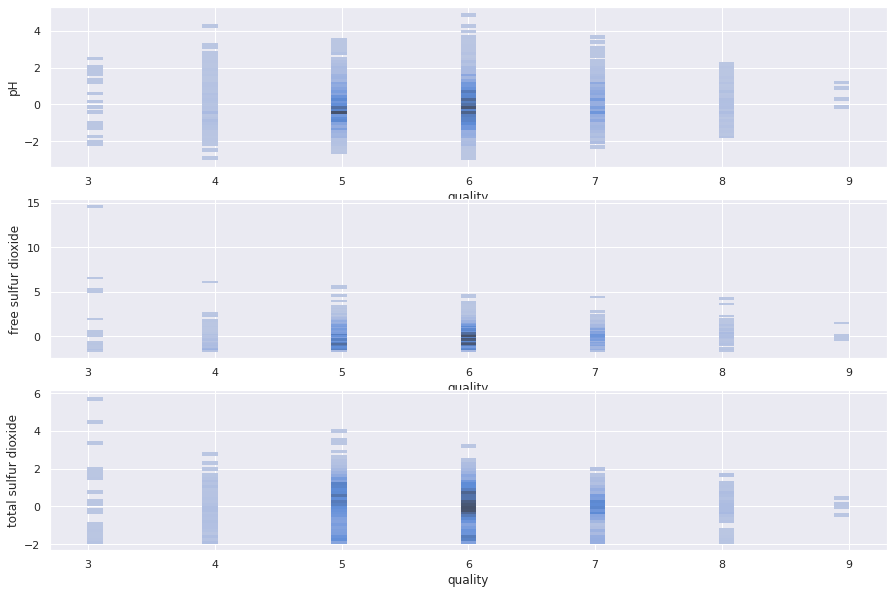

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
sns.histplot(x = df['quality'], y = df['pH'], palette = 'Paired',multiple='fill')

plt.subplot(3,1,2)

sns.histplot(x = df['quality'], y = df['free sulfur dioxide'], palette = 'Paired',multiple='fill')

plt.subplot(3,1,3)

sns.histplot(x = df['quality'], y = df['total sulfur dioxide'], palette = 'Paired')

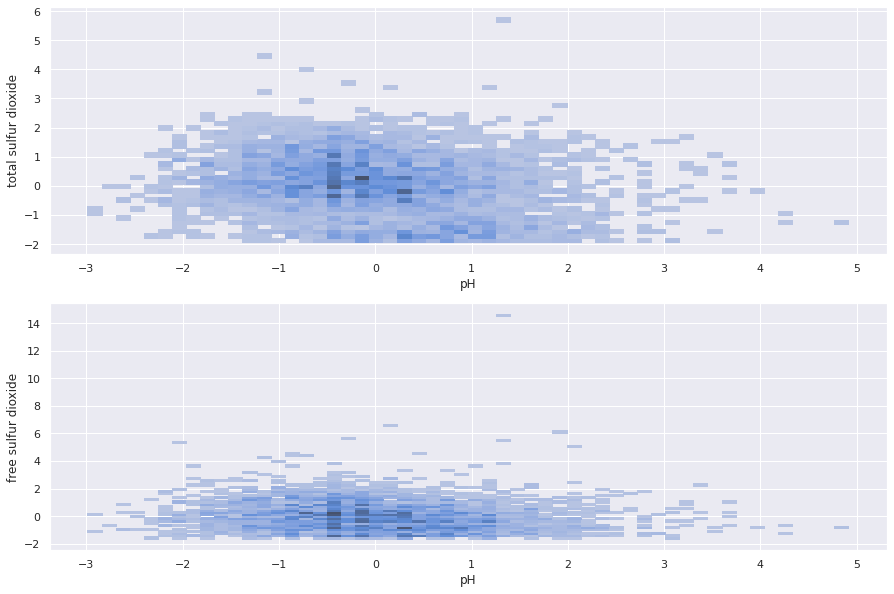

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.histplot(x = df['pH'], y = df['total sulfur dioxide'], palette = 'Paired')

plt.subplot(2,1,2)
sns.histplot(x = df['pH'], y = df['free sulfur dioxide'], palette = 'Paired')

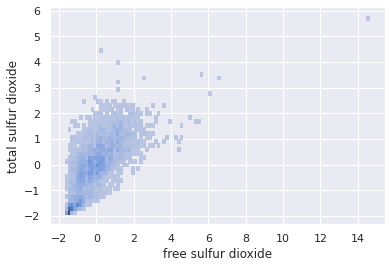

In [15]:
sns.histplot(x = df['free sulfur dioxide'], y = df['total sulfur dioxide'], palette = 'Paired',multiple='fill')

In [16]:
df11 = df
for i in range(0, len(features)):
    low_line = df11[features[i]].mean() - 3*df11[features[i]].std()
    high_line = df11[features[i]].mean() + 3*df11[features[i]].std()

    df11 = df11[(df[features[i]] > low_line) & (df11[features[i]] < high_line)]

df11.shape ,df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


((5028, 14), (5497, 14))

## ML

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve,accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

features = list(df.columns)
features.remove(target)

train, val = train_test_split(df, random_state = 42, test_size = 0.25, train_size = 0.75 )
train11, val11 = train_test_split(df11, random_state = 42, test_size = 0.25, train_size = 0.75 )

X_train = train[features]
y_train = train[target]

X_train11 = train11[features]
y_train11 = train11[target]

X_val = val[features]
y_val = val[target]

X_val11 = val11[features]
y_val11 = val11[target]

X_df = df[features]
y_df = df[target]

X_df11 = df11[features]
y_df11 = df11[target]

In [18]:
# xg = XGBClassifier(n_estimators=288
#                 , random_state=2
#                 , n_jobs=-1
#                 ,scale_pos_weight= 3
#                 ,num_boost_roun= 0
#                 ,max_depth= 15
#                 ,learning_rate= 0.05
#                 ,gamma= 1
#                  )

# xg.fit(X_train, y_train)

# print(xg.score(X_train, y_train))
# print(xg.score(X_val, y_val))

In [19]:
# xg.fit(X_train11, y_train11)

# print(xg.score(X_train11, y_train11))
# print(xg.score(X_val11, y_val11))

## LGB

https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [20]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from lightgbm import LGBMClassifier

In [21]:
rows_train = df11.shape[0] # 주어진 train data의 row 수
rows_test = df11.shape[0] # 주어진 test data의 row 수
num_classes = len(y_df11.unique())
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 3 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_tr = 5 # 트레이닝 seed 개수
sel_seed = 4 # 선택할 seed 개수

pred_dict = {}
pred_test_dict = {}

In [22]:

def lgb_objective(trial: Trial, X , y, p, d):
        params_lgb = {
            "random_state": basic_seed,
            "verbosity": -1,
            "n_estimators": 10000,
            "objective": "multiclass",
            "metric": "multi_logloss",
            "num_class": 7,
            "learning_rate": trial.suggest_uniform("learning_rate", 0.04, 0.1), # default=0.1, range=[0,1]
            "max_depth": trial.suggest_int("max_depth", 5, 12), # default=-1
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+0), # default=0
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+1), # default=0
            "num_leaves": trial.suggest_int("num_leaves", 31, 100), # default=31, range=(1,130172]
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 0.8), # feature_fraction, default=1
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0), # bagging_fraction, default=1, range=[0,1]
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 20), # bagging_freq, default=0
            "min_child_samples": trial.suggest_int("min_child_samples", 20, 30), # min_data_in_leaf, default=20 
            "max_bin": trial.suggest_int("max_bin", 100, 400)
        }

        model = LGBMClassifier(**params_lgb)
        lgb_model = model.fit(X, y, verbose=-1)

        score = accuracy_score(lgb_model.predict(p), d)
        return score

In [23]:
# study = optuna.create_study(direction='maximize', sampler=TPESampler())

# study.optimize(lambda trial : lgb_objective(trial, X_train11, y_train11, X_val11, y_val11))
# print(study.best_trial.value)
# print(study.best_trial.params)


In [30]:
lgb_best = LGBMClassifier(learning_rate = 0.09794861466327637
                          , max_depth = 11
                          , reg_alpha = 0.05391808310433681
                          , reg_lambda = 0.033948948355192535
                          , num_leaves = 85
                          , colsample_bytree = 0.6273896870854622
                          , subsample = 0.9921175439507407
                          , subsample_freq = 16
                        #   , min_child_samples = 24
                          , max_bin = 199
                          , verbosity = -1
                          , n_estimators = 10000
                          , objective = 'multiclass'
                          , metric = 'multi_logloss'
                          , num_class = 7
                          )

lgb_bestmodel = lgb_best.fit(X_train11, y_train11, verbose=-1)

score = accuracy_score(lgb_bestmodel.predict(X_val11), y_val11)
print(score)

0.6579156722354813


In [31]:
test_result = []

test_pred = lgb_bestmodel.predict(test)
test_result.append(test_pred)
test_result[0]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [34]:
# 제출
submission = pd.read_csv("/content/drive/MyDrive/Colab/Wine_quality/sample_submission.csv")
submission['quality'] = test_result[0]
submission.to_csv('submission_lgb2.csv', index=False)